In [1]:
import torch as t
from scipy import ndimage
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [2]:
#device = t.device('cuda' if t.cuda.is_available() else 'cpu')
device = t.device('cpu')

In [3]:
def simple_res_plot(temps, grads, losses):
    plt.plot(temps.cpu(), grads, label="gradient")
    plt.plot(temps.cpu(), losses, label="loss")
    plt.plot(temps.cpu(), t.exp(-temps).cpu(), label="probability")

    plt.hlines(y=[0.], xmin=0, xmax=5, label="0-grad line", linestyles="dashed", colors=["gray"])

    plt.legend()
    plt.show()

In [4]:
def create_dist_matrix(batch:t.Tensor):
    dist_matrix:np.ndarray = ndimage.distance_transform_edt(1-batch[0].cpu(), return_indices=False)
    dist_matrix = dist_matrix**2
    dist_matrix_t = t.from_numpy(dist_matrix).to(device)
    return dist_matrix_t

In [5]:
MOORE_OFFSETS = t.tensor([(1, 1), (1, -1), (1, 0), (-1, 0), (0, 0), (-1, 1), (-1, -1), (0, 1), (0, -1)], device=device)
def get_moore_nbh(batch:t.Tensor):
    _, batch_height, _ = batch.shape
    cell_pixel_coords = (batch == 1).nonzero()
    nbh_coords = (cell_pixel_coords[:, 1:].unsqueeze(1)+MOORE_OFFSETS.type(t.float).unsqueeze(0))
    idx_pad = cell_pixel_coords[:, 0].repeat(9,1).T.reshape(cell_pixel_coords[:, 0].shape[0], 9, 1)
    nbh_coords[nbh_coords == -1] = 1
    nbh_coords[nbh_coords == batch_height] = batch_height -2
    return t.concatenate((idx_pad, nbh_coords), dim=-1)

In [29]:
STEP_SIZES = t.tensor([(1, 0), (0, 1), (-1, 0), (0, -1), (1, 1), (1, -1), (-1, 1), (-1, -1)], device=device)
def MCS(batch, temperature):
    batch_size, batch_height, _ = batch.shape
    
    #########################################################
    # 1. Find source and target coordinates for each sample #
    #########################################################
    # Find all pixels that belong to a cell, or border a cell 
    frontiers = get_moore_nbh(batch)
    src_coords = []
    for batch_idx in range(batch_size):
        frontier = frontiers[frontiers[:, :, 0] == batch_idx, :].unique(dim=0)
        src_coords.append(random.choice(frontier).type(t.long))
    batch_src_coords = t.vstack(src_coords)
    p_f = np.sqrt(2.)
    p_side = (p_f - 1)*p_f/4
    p_diag = (p_f - 1)/4
    step_size_idx = t.tensor(np.random.choice(
            STEP_SIZES.shape[0],
            size=batch_src_coords.shape[0],
            replace=True,
            p=[p_side, p_side, p_side, p_side, p_diag, p_diag, p_diag, p_diag])).type(t.long)
    step_sizes = STEP_SIZES[step_size_idx]
    tgt_coords = t.hstack((batch_src_coords[:, 0].unsqueeze(0).T, batch_src_coords[:, 1:] + step_sizes))
    tgt_coords[:, 1:][tgt_coords[:, 1:] == -1] = 1
    tgt_coords[:, 1:][tgt_coords[:, 1:] == batch_height] = batch_height -2
    tgt_i = tgt_coords[:, 0]
    tgt_j = tgt_coords[:, 1]
    tgt_k = tgt_coords[:, 2]
    src_i = batch_src_coords[:, 0]
    src_j = batch_src_coords[:, 1]
    src_k = batch_src_coords[:, 2]
    
    #########################################################################
    # 2. Calculate the changes in volume that the copy attempts would cause #
    #########################################################################
    current_volumes = t.sum(batch, dim=(-1, -2))
    vol_changes = (-1 * batch[tgt_i, tgt_j, tgt_k]) + batch[src_i, src_j, src_k]
    adjusted_vols = current_volumes + vol_changes
    
    #########################################################
    # 3. Define boolean masks based on the volume changes   #
    #########################################################
    sml_eq_two_mask = adjusted_vols <= 2
    greater_zero_mask = adjusted_vols > 0
    vol_change_positive_mask = vol_changes > 0
    vol_change_negative_mask = vol_changes < 0
    
    #########################################################
    # 4. auto accept each attempt with negative vol. change #
    # that fulfills the hard volume constraint              #
    #########################################################
    auto_upd_mask = t.logical_and(
        vol_change_negative_mask,
        greater_zero_mask
    )
    auto_upd_i = tgt_i[auto_upd_mask]
    auto_upd_j = tgt_j[auto_upd_mask]
    auto_upd_k = tgt_k[auto_upd_mask]
    batch[auto_upd_i, auto_upd_j, auto_upd_k] += vol_changes[auto_upd_mask]
    
    ##################################################################
    # 5. stochastic update of the attempts with positive vol. change #
    ################################################################## 
    update_mask = t.logical_and(
        vol_change_positive_mask,
        sml_eq_two_mask
    )
    update_probability = t.exp(-temperature)
    logit = t.log(t.hstack((update_probability, (1-update_probability))))
    batch_logits = logit.repeat((vol_changes[update_mask].shape[0],1))
    one_hot = t.nn.functional.gumbel_softmax(batch_logits, hard=True)
    
    upd_vals = one_hot[:, 0] * vol_changes[update_mask]
    upd_i = tgt_i[update_mask]
    upd_j = tgt_j[update_mask]
    upd_k = tgt_k[update_mask]
    batch[upd_i, upd_j, upd_k] += upd_vals.squeeze()
    
    return batch
    

In [30]:
temperature = t.tensor(1.)
target_vol = 1.
batch = t.zeros(1,256,256, device=device)
batch[:,128,128] += 1

states = []
for i in tqdm(range(1000)):
    batch = MCS(batch, temperature)
    if t.any(t.sum(batch, dim=(-1,-2)) == 0) or t.any(t.sum(batch, dim=(-1,-2)) > 2):
        print("ISSUE DETECTED, STOP SIM")
        break
    else:
        states.append(batch[0].detach().clone().cpu().numpy())

imgs = [Image.fromarray((1-state)*255) for state in states]
print(len(imgs))
imgs[0].save("test.gif", save_all=True, append_images=imgs[1:], fps=20)

100%|██████████| 1000/1000 [00:01<00:00, 509.49it/s]


1000


In [31]:
def step(batch:t.Tensor, dist_matrix:t.Tensor, temperature:t.Tensor, eta:float, num_steps:int, target_distance:float):
    for i in tqdm(range(num_steps)):
        batch = MCS(batch, temperature)
        if t.any(t.sum(batch, dim=(-1,-2)) == 0) or t.any(t.sum(batch, dim=(-1,-2)) > 2):
            print("ISSUE DETECTED, STOP SIM")
            return None, None
    # calc the distance after 100 steps    
    distances = t.sum(batch * dist_matrix, dim=(-1,-2)) / t.sum(batch, dim=(-1,-2))
    mean_distance = t.mean(distances)
    print(f"temperature: {temperature}, update_prob:{t.exp(-temperature)} mean distance: {mean_distance}")
    loss = (mean_distance - target_distance)**2
    grad = t.autograd.grad(loss, temperature)[0]
    print(f"gradient: {grad}")
    return t.clamp(temperature - (eta * grad), min=1e-5, max=40.), grad, mean_distance, loss

In [ ]:
temps1 = t.linspace(0,1,30)
temps2 = t.linspace(1, 5, 20)
temps = t.cat((temps1, temps2))
ref = t.zeros(1,16,16, device=device)
ref[:,8,8] += 1
dist_matrix = create_dist_matrix(ref)
target_distance = 2.

grads = []
mean_distances = []
losses = []
for temp in temps:
    temp.requires_grad_()
    batch = t.zeros(1000,16,16, device=device)
    batch[:,8,8] += 1
    new_temp, grad, mean_distance, loss = step(batch, dist_matrix, temp, eta=1, num_steps=100, target_distance=target_distance)
    grads.append(grad.detach().cpu().numpy())
    mean_distances.append(mean_distance.detach().cpu().numpy())
    losses.append(loss.detach().cpu().numpy())

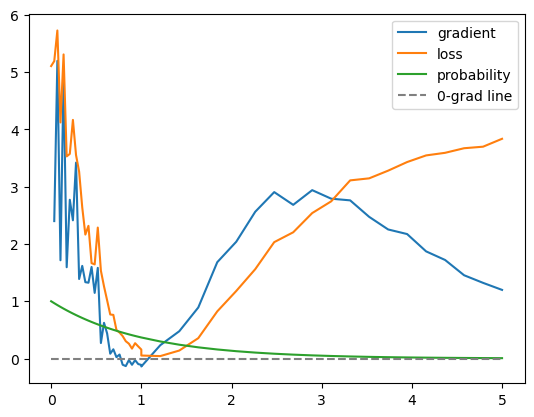

In [33]:
simple_res_plot(temps, grads, losses)

In [36]:
ref = t.zeros(1,8,8, device=device)
ref[:,4,4] += 1
create_dist_matrix(ref)

tensor([[32.0000, 25.0000, 20.0000, 17.0000, 16.0000, 17.0000, 20.0000, 25.0000],
        [25.0000, 18.0000, 13.0000, 10.0000,  9.0000, 10.0000, 13.0000, 18.0000],
        [20.0000, 13.0000,  8.0000,  5.0000,  4.0000,  5.0000,  8.0000, 13.0000],
        [17.0000, 10.0000,  5.0000,  2.0000,  1.0000,  2.0000,  5.0000, 10.0000],
        [16.0000,  9.0000,  4.0000,  1.0000,  0.0000,  1.0000,  4.0000,  9.0000],
        [17.0000, 10.0000,  5.0000,  2.0000,  1.0000,  2.0000,  5.0000, 10.0000],
        [20.0000, 13.0000,  8.0000,  5.0000,  4.0000,  5.0000,  8.0000, 13.0000],
        [25.0000, 18.0000, 13.0000, 10.0000,  9.0000, 10.0000, 13.0000, 18.0000]],
       dtype=torch.float64)